$\Huge Compute$ $\hspace{0.1cm}$ $\Huge the$ $\hspace{0.1cm}$ $\Huge power$ $\hspace{0.1cm}$ $\Huge spectrum$ $\hspace{0.1cm}$ $\Huge of$ $\hspace{0.1cm}$  $\Huge y_{ILC}$ $\hspace{0.1cm}$ $\Huge and$ $\hspace{0.1cm}$ $\Huge true$ $\hspace{0.1cm}$ $\Huge y$ $\hspace{0.1cm}$ $\Huge :$ 

# Modules : 

In [2]:
import CILC as CILC 
import ccatp_sky_model as sky
import healpy as hp
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import numpy as np
import pymaster as PyM
import fMaps as fM
from matplotlib.ticker import MaxNLocator

In [3]:
mask = sky.return_mask('Dust', nside_out = 4096, coord = 'G')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


# Code : 

In [4]:
def residual_noise(dic_freq,noise,beam,ILC_compo,noise_compo,nside_maps,nside_tess,mask_typ,unit):
    
    #Create the maps for the ILC, containing all the components : 
    P_maps_array =[]
    
    for i in range(len(dic_freq)): 
        
        full_sky = sky.ccatp_sky_model(freq=dic_freq[i]*1e9, sensitivity=noise[i], components=ILC_compo,
                                       red_noise=False,cl_file=None, lensed=False, out_file=None, 
                                       nside_out=nside_maps,lmax=None, beam_FWHM=beam[i], template='WebSky',
                                       unit=unit)
    
        P_maps_array.append(full_sky)
    
    
    #Tessalate the maps : 
    nfields = hp.nside2npix(nside_tess) 
    npix = hp.nside2npix(nside_maps)
    It = int(npix/nfields)
    
    ##Index of the dictonary containing the lowest beam resolution: 
    index_reso = max(beam, key=beam.get)
    
    ##Mask : 
    mask = sky.return_mask(mask_typ, nside_out = nside_maps, coord = 'G')
    
    cube = CILC.map2fields(maps_array=P_maps_array,It=It,nfields=nfields,wt_reso=beam[index_reso],
                       dic_reso=beam,median=True,gauss=False,mask=mask,dic_freq=dic_freq)

    #Apply the ILC : 
    #P_ILC_y = CILC.All_sky_ILC(dic_freq=dic_freq,maps_array=P_maps_array,nside_map=nside_maps,
    #                           nside_tess=nside_tess,wt_reso=beam[index_reso],dic_reso=beam,median=True,
    #                           gauss=False,CILC=False,mask=mask)
    
    
    #Create the noise map: 
    P = []
    if noise_compo == ['noise']:
              
        
        for i in range(len(dic_freq)): 
    
            Noise=sky.simulate_white_noise(freq=dic_freq[i]*1e9, noise_level=noise[i], nside_out = nside_maps,
                                        unit_noise = 1, arcmin = True, unit = unit)
    
            P.append(Noise)
    else: 
        
                
        for i in range(len(dic_freq)): 
            
            Noise = sky.ccatp_sky_model(freq=dic_freq[i]*1e9, sensitivity=None, components=noise_compo,
                                           red_noise=False,cl_file=None, lensed=False, out_file=None, 
                                           nside_out=nside_maps,lmax=None, beam_FWHM=beam[i], 
                                           template='WebSky',unit=unit)            
            P.append(Noise)
        
    #Tessalate the maps containing the noise components : 
    N_cube = CILC.map2fields(maps_array=P,It=It,nfields=nfields,wt_reso=beam[index_reso],
                                 dic_reso=beam,median=True,gauss=False,mask=mask,dic_freq=dic_freq)
        
    #Apply ILC to the noise maps, using the coefficients from the full maps : 
    l=0
    fmap = np.zeros(npix)
    
    
    for i in range(0,npix,It):    
        
        cov_mat = CILC.covcorr_matrix(cube[:,l,:] ,rowvar=False,mask=mask,dic_freq=dic_freq)
        mix = CILC.mixing_vector_tSZ(dic_freq=dic_freq,MJy=True)
        y = CILC.ILC_weights(mix_vect=mix,data=N_cube,cov_matrix=cov_mat[0],k=l,nside_tess=nside_tess)  
        y = y[0]
        fmap[i:i+It]+=y
        l=l+1
    
    return fmap 

## True y map : 

### For FYST alone : 

In [4]:
Py_b = sky.simulate_tSZ(freq=-1, nside_out = 4096, lmax = None, beam_FWHM = 2.2, template = 'WebSky',
                      unit = 'mjy')

Py_map_b = Py_b * mask

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
begin smoothing
Sigma is 0.934254 arcmin (0.000272 rad) 
-> fwhm is 2.200000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [5]:
#hp.write_map('masked_Py_b.fits',Py_map_b,overwrite=True) 

# Read healpix maps and initialize a spin-0 and spin-2 field
P_y_b = PyM.NmtField(mask,[hp.read_map('masked_Py_b.fits', field=0, verbose=False)])


# Initialize binning scheme with 4 ells per bandpower
bP_y_b = PyM.NmtBin.from_nside_linear(4096, 50)

# Compute MASTER estimator spin-0 x spin-0
cl_P_y_b = PyM.compute_full_master(P_y_b, P_y_b, bP_y_b)

### For SO and SO+FYST 

In [6]:
Py = sky.simulate_tSZ(freq=-1, nside_out = 4096, lmax = None, beam_FWHM = None, template = 'WebSky',
                      unit = 'mjy')

Py_map = Py * mask

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [6]:
#hp.write_map('masked_Py.fits',Py_map,overwrite=True) 

# Read healpix maps and initialize a spin-0 and spin-2 field
P_y = PyM.NmtField(mask,[hp.read_map('masked_Py.fits', field=0, verbose=False)])


# Initialize binning scheme with 4 ells per bandpower
bP_y = PyM.NmtBin.from_nside_linear(4096, 50)

# Compute MASTER estimator spin-0 x spin-0
cl_P_y = PyM.compute_full_master(P_y, P_y, bP_y)

## SO : 

### SO ILC : 

In [8]:
freq_SO = [93e9,145e9,220e9,280e9]
noise_SO = [8,10,22,54] 
beam_SO = {0:2.2,1:1.4,2:1.0, 3:0.9}
dic_freq_SO = {0:93,1:145,2:220,3:280}

In [9]:
index_reso = max(beam_SO, key=beam_SO.get)

In [10]:
P_maps_array_SO =[]
for i in range(len(dic_freq_SO)): 
    full_sky = sky.ccatp_sky_model(freq=freq_SO[i], sensitivity=noise_SO[i], components=['tsz','cib','cmb','ksz'],
                                   red_noise=False,cl_file=None, lensed=False, out_file=None, nside_out=4096,
                                   lmax=None, beam_FWHM=beam_SO[i], template='WebSky', unit='mjy')
    
    P_maps_array_SO.append(full_sky)

Computing CIB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CIB complete.
Computing CMB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CMB complete.
Computing tSZ...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
tSZ complete.
Computing kSZ...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
kSZ complete.
Begin smoothing...
Sigma is 0.934254 arcmin (0.000272 rad) 
-> fwhm is 2.200000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Smoothing complete.
Computing white noise...
White noise complete.
Done!
Computing CIB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CIB complete.
Computing CMB...
NSIDE = 4096
ORDERING = RING in fits file


In [11]:
A=[1]
B_SO=CILC.mixing_vector_tSZ(dic_freq_SO,MJy=True)
ILC_SO = CILC.All_sky_ILC(dic_freq=dic_freq_SO,#,6:350,7:405,8:860}, #,5:857},
                    maps_array=P_maps_array_SO,
                    nside_map=4096,
                    nside_tess=4,
                    wt_reso=beam_SO[index_reso],
                    dic_reso=beam_SO,
                    median=True,
                    gauss=False,
                    CILC=False,
                    mask=mask,
                    mix_vec_min=A,
                    mix_vec_max=B_SO)

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.720673 arcmin (0.000210 rad) 
-> fwhm is 1.697056 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.832162 arcmin (0.000242 rad) 
-> fwhm is 1.959592 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.852501 arcmin (0.000248 rad) 
-> fwhm is 2.007486 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/CILC-1.0-py3.6.egg/CILC/CILC.py:258: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(data,y = None, rowvar = rowvar) #Compute the covariance matrix
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2526

original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [-9.89579015e-04 -5.72438231e-05  4.81045706e-04 -8.54596163e-06]
Sum of the ILC weights :  1.0000000000000002
original ILC weights [-9.82481493e-04 -6.40809689e-05  4.81862097e-04 -9.17674392e-06]
Sum of the ILC weights :  1.0000000000000004
original ILC weights [-1.02123904e-03 -4.14648756e-05  4.92743110e-04 -1.98042363e-05]
Sum of the ILC weights :  1.0
original ILC weights [-1.12021195e-03  7.88072646e-06  5.25604020e-04 -5.47611566e-05]
Sum of the ILC weights :  1.0000000000000002
original ILC weights [-1.18485259e-03  2.80536217e-05  5.60034981e-04 -8.91412828e-05]
Sum of the ILC weights :  1.0
original ILC weights [-1.03059959e-03 -4.03764192e-05  4.96690861e-04 -2.63591754e-05]
Sum of the ILC weights :  1.0000000000000007
original ILC weights [-1.21395398e-03  3.80293975e-05  5.81313000e-04 -1.04164660e-04]
Sum of the ILC weights :  0.9999999999999992
original ILC weights [-1.01322333e-03

original ILC weights [-9.85082174e-04 -6.23605708e-05  4.81226341e-04 -9.62713508e-06]
Sum of the ILC weights :  0.9999999999999999
original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [-9.20418625e-04 -9.33620841e-05  4.48652136e-04  1.49806233e-05]
Sum of the ILC weights :  0.9999999999999999
original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan]
Sum of 

original ILC weights [-9.93540180e-04 -5.87544620e-05  4.86029473e-04 -1.32794301e-05]
Sum of the ILC weights :  0.9999999999999999
original ILC weights [-9.27794572e-04 -7.97035119e-05  4.49377649e-04  2.14001473e-05]
Sum of the ILC weights :  0.9999999999999993
original ILC weights [-9.63294880e-04 -9.08514726e-05  5.02533340e-04 -1.93908999e-05]
Sum of the ILC weights :  0.9999999999999991
original ILC weights [-9.96252083e-04 -5.58159247e-05  4.83091668e-04 -1.25903684e-05]
Sum of the ILC weights :  1.0
original ILC weights [-9.88432345e-04 -6.59589234e-05  4.90369689e-04 -1.59987235e-05]
Sum of the ILC weights :  1.0
original ILC weights [-1.00008695e-03 -5.55946525e-05  4.89307321e-04 -1.57507416e-05]
Sum of the ILC weights :  1.0000000000000002
original ILC weights [-9.96363563e-04 -5.52856272e-05  4.83483457e-04 -1.22265500e-05]
Sum of the ILC weights :  1.0000000000000007
original ILC weights [-1.00420162e-03 -4.88751942e-05  4.82996192e-04 -1.25737546e-05]
Sum of the ILC weig

In [12]:
ILC_SO[0][np.isnan(ILC_SO[0])] = 0
P_ILC_y_SO = hp.pixelfunc.reorder(ILC_SO[0], n2r = True)

In [7]:
#hp.write_map('yILC_SO_Extra.fits',P_ILC_y_SO,overwrite=True) 

# Read healpix maps and initialize a spin-0 and spin-2 field
P_ILC_SO = PyM.NmtField(mask,[hp.read_map('yILC_SO_Extra.fits', field=0, verbose=False)])


# Initialize binning scheme with 4 ells per bandpower
bP_ILC_SO = PyM.NmtBin.from_nside_linear(4096, 50)

# Compute MASTER estimator spin-0 x spin-0
cl_ILC_SO = PyM.compute_full_master(P_ILC_SO, P_ILC_SO, bP_ILC_SO)

### Residual White noise : 

In [14]:
fmap = residual_noise(dic_freq={0:93,1:145,2:220,3:280},
               noise=[8,10,22,54],
               beam={0:2.2,1:1.4,2:1.0, 3:0.9},
               ILC_compo=['tsz','cib','cmb','ksz'],noise_compo=['noise'],nside_maps=4096,nside_tess=4,
               mask_typ='Dust',unit='mjy')

fmap[np.isnan(fmap)] = 0
fmap = hp.pixelfunc.reorder(fmap, n2r = True)

Computing CIB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CIB complete.
Computing CMB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CMB complete.
Computing tSZ...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
tSZ complete.
Computing kSZ...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
kSZ complete.
Begin smoothing...
Sigma is 0.934254 arcmin (0.000272 rad) 
-> fwhm is 2.200000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Smoothing complete.
Computing white noise...
White noise complete.
Done!
Computing CIB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CIB complete.
Computing CMB...
NSIDE = 4096
ORDERING = RING in fits file


/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/CILC-1.0-py3.6.egg/CILC/CILC.py:258: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(data,y = None, rowvar = rowvar) #Compute the covariance matrix
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2526

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.80969312e-04 -6.60224778e-05  4.85510240e-04 -9.95159460e-06]
Sum of the ILC weights :  0.9999999999999993
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.91901278e-04 -5.29800121e-05  4.74656833e-04 -6.16297911e-06]
Sum of the ILC weights :  1.0000000000000002
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.016748

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.60306814e-04 -9.15776190e-05  4.99622415e-04 -1.75385408e-05]
Sum of the ILC weights :  0.9999999999999999
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.20877860e-03  2.94405031e-05  5.81781294e-04 -1.07838043e-04]
Sum of the ILC weights :  1.0000000000000018
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.84101033e-04 -6.16719475e-05  4.77919092e-04 -8.05005537e-06]
Sum of the ILC weights :  1.0000000000000004
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.774

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.93487063e-04 -7.17583739e-05  5.06397480e-04 -2.60761960e-05]
Sum of the ILC weights :  0.9999999999999998
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.00773553e-03 -4.97964678e-05  4.89885219e-04 -1.65611024e-05]
Sum of the ILC weights :  1.0
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.59885769e-04 -8.93299004e-05  4.95414575e-04 -1.49504816e-05]
Sum of the ILC weights :  1.0
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711

Sum of the ILC weights :  0.9999999999999998
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.29296855e-04 -7.02366023e-05  3.39130940e-04  3.52639517e-05]
Sum of the ILC weights :  1.0000000000000002
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.91176868e-04 -6.14926798e-05  4.89206673e-04 -1.40752783e-05]
Sum of the ILC weights :  0.9999999999999991
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.22341193e-03  5.89729433e-05  5.61302585e-04 -9.16191644e-05]
Sum of the ILC weights :  1.0000000000000007
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-

Sum of the ILC weights :  1.0000000000000007
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.01886903e-03 -4.64143561e-05  4.93174861e-04 -2.24078189e-05]
Sum of the ILC weights :  1.0000000000000002
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.00417377e-03 -5.07917581e-05  4.88081830e-04 -1.45684030e-05]
Sum of the ILC weights :  0.9999999999999998
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.92838986e-04 -6.86729221e-05  4.99119366e-04 -2.23794041e-05]
Sum of the ILC weights :  0.9999999999999999
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.99126952e-04 -5.68933426e-05  4.90580558e-04 -1.62396128e-05]
Sum of the ILC weights :  0.9999999999999996
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.96166915e-04 -5.59940035e-05  4.84222302e-04 -1.27505960e-05]
Sum of the ILC weights :  1.0000000000000002
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.98774416e-04 -5.62273142e-05  4.88927623e-04 -1.52710751e-05]
Sum of the ILC weights :  0.9999999999999996
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.774

Sum of the ILC weights :  0.9999999999999999
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.81777491e-04 -7.97518035e-05  5.05730974e-04 -2.40590326e-05]
Sum of the ILC weights :  0.9999999999999996
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-0.00184604  0.00037004  0.00077355 -0.00031129]
Sum of the ILC weights :  1.0000000000000002
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.20822208e-03  3.46663931e-05  5.70174477e-04 -1.02041240e-04]
Sum of the ILC weights :  0.9999999999999988
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.987007003179

In [8]:
#hp.write_map('SO_rN_WN_Extra.fits',fmap,overwrite=True) 

# Read healpix maps and initialize a spin-0 and spin-2 field
P_Nr = PyM.NmtField(mask,[hp.read_map('SO_rN_WN_Extra.fits', field=0, verbose=False)])


# Initialize binning scheme with 4 ells per bandpower
bP_Nr = PyM.NmtBin.from_nside_linear(4096, 50)

# Compute MASTER estimator spin-0 x spin-0
cl_P_Nr = PyM.compute_full_master(P_Nr, P_Nr, bP_Nr)

### Residual CIB noise : 

In [16]:
fmap_CIB = residual_noise(dic_freq={0:93,1:145,2:220,3:280},
               noise=[8,10,22,54],
               beam={0:2.2,1:1.4,2:1.0, 3:0.9},
               ILC_compo=['tsz','cib','cmb','ksz'],noise_compo=['cib'],nside_maps=4096,nside_tess=4,
               mask_typ='Dust',unit='mjy')

fmap_CIB[np.isnan(fmap_CIB)] = 0
fmap_CIB = hp.pixelfunc.reorder(fmap_CIB, n2r = True)

Computing CIB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CIB complete.
Computing CMB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CMB complete.
Computing tSZ...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
tSZ complete.
Computing kSZ...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
kSZ complete.
Begin smoothing...
Sigma is 0.934254 arcmin (0.000272 rad) 
-> fwhm is 2.200000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Smoothing complete.
Computing white noise...
White noise complete.
Done!
Computing CIB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CIB complete.
Computing CMB...
NSIDE = 4096
ORDERING = RING in fits file


/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/CILC-1.0-py3.6.egg/CILC/CILC.py:258: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(data,y = None, rowvar = rowvar) #Compute the covariance matrix
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2526

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [nan nan nan nan]
Sum of the ILC weights :  nan
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.77413069e-04 -6.78322678e-05  4.84407083e-04 -8.73299749e-06]
Sum of the ILC weights :  1.0
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.78364436e-04 -6.81604077e-05  4.84278424e-04 -9.75983370e-06]
Sum of the ILC weights :  0.9999999999999998
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.02034578e-03 -4.41084

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.69214563e-04 -8.35930920e-05  4.97037998e-04 -1.71870417e-05]
Sum of the ILC weights :  0.9999999999999996
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.20861395e-03  2.79032639e-05  5.84257881e-04 -1.09231520e-04]
Sum of the ILC weights :  0.9999999999999998
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.83451647e-04 -6.11721207e-05  4.76998733e-04 -7.04248441e-06]
Sum of the ILC weights :  0.9999999999999994
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.774

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.88926970e-04 -7.54625316e-05  5.07151609e-04 -2.58795844e-05]
Sum of the ILC weights :  1.0000000000000002
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.00739697e-03 -5.16300987e-05  4.92791300e-04 -1.81096253e-05]
Sum of the ILC weights :  1.0
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.59793952e-04 -9.01176262e-05  4.96729737e-04 -1.56614826e-05]
Sum of the ILC weights :  1.0
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-7.55072375e-04 -2.44965594e-04  4.24406798e-04  9.72700326e-06]
Sum of the ILC weights :  1.0000000000000002
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.00707808e-03 -4.90814148e-05  4.87465962e-04 -1.52655162e-05]
Sum of the ILC weights :  1.0000000000000009
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.23822113e-03  7.28954394e-05  5.55938719e-04 -9.03917917e-05]
Sum of the ILC weights :  0.9999999999999999
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.774

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.84047779e-04 -6.26719764e-05  4.80894389e-04 -9.07983615e-06]
Sum of the ILC weights :  0.9999999999999989
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.02741847e-03 -4.05360816e-05  4.93754434e-04 -2.38485276e-05]
Sum of the ILC weights :  1.0
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.00358826e-03 -5.26340574e-05  4.90360202e-04 -1.58948629e-05]
Sum of the ILC weights :  0.9999999999999991
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 11

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.85413622e-04 -6.92536848e-05  4.92469127e-04 -1.67171968e-05]
Sum of the ILC weights :  1.0
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.00354477e-03 -5.20417045e-05  4.87293785e-04 -1.51486939e-05]
Sum of the ILC weights :  1.0000000000000009
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.88296055e-04 -6.11682629e-05  4.83643051e-04 -1.12092660e-05]
Sum of the ILC weights :  1.0000000000000009
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 11

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-1.04321767e-03 -3.07821659e-05  4.97856436e-04 -2.76829375e-05]
Sum of the ILC weights :  1.0000000000000002
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-9.89051042e-04 -7.35898124e-05  5.04025830e-04 -2.41159212e-05]
Sum of the ILC weights :  0.9999999999999999
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711]
original ILC weights [-0.00184576  0.00036947  0.00077385 -0.0003116 ]
Sum of the ILC weights :  1.0000000000000009
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 118

In [9]:
#hp.write_map('SO_rN_CIB_Extra.fits',fmap_CIB,overwrite=True) 

# Read healpix maps and initialize a spin-0 and spin-2 field
P_Nr_CIB = PyM.NmtField(mask,[hp.read_map('SO_rN_CIB_Extra.fits', field=0, verbose=False)])


# Initialize binning scheme with 4 ells per bandpower
bP_Nr_CIB = PyM.NmtBin.from_nside_linear(4096, 50)

# Compute MASTER estimator spin-0 x spin-0
cl_P_Nr_CIB = PyM.compute_full_master(P_Nr_CIB, P_Nr_CIB, bP_Nr_CIB)

### Weights study : 

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_man

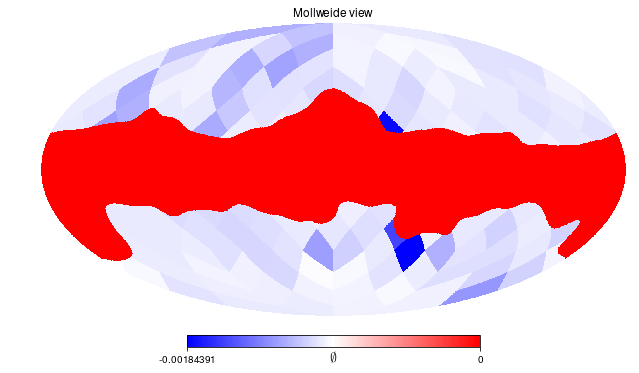

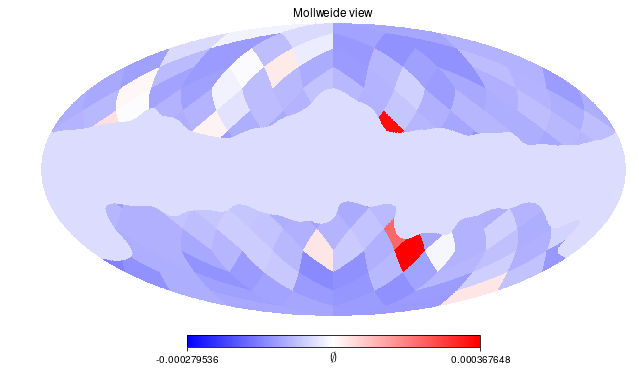

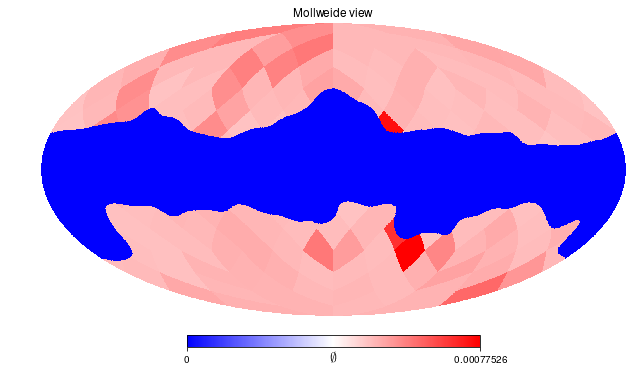

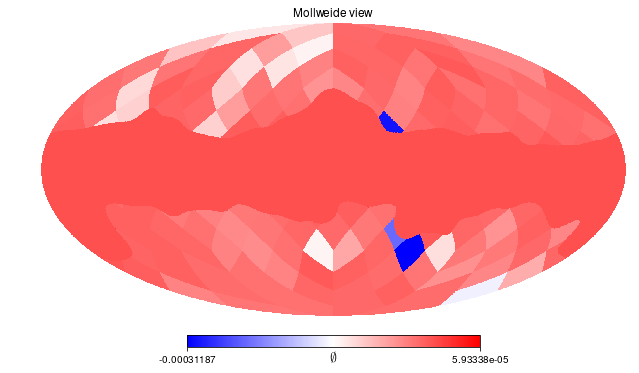

In [18]:
CILC.weight_maps(data=ILC_SO[1],nside=4096,nside_tess=4,dic_freq=dic_freq_SO,mask=mask)

In [19]:
w_histo = CILC.weight_histo(data=ILC_SO[1],dic_freq=dic_freq_SO)

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


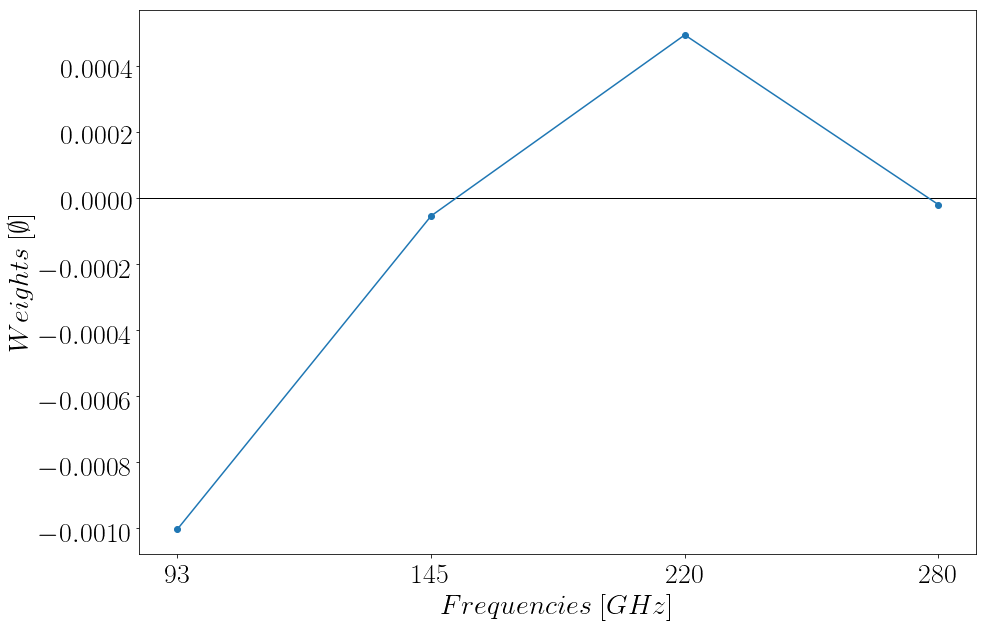

In [55]:
fig, ax = plt.subplots()
ax.axhline(y=0,color='black', lw=1)
plt.rcParams['figure.figsize'] = [15,10]
plt.plot(['$93$','$145$','$220$','$280$'],w_histo,'o-')
plt.title('',fontsize=28) 
plt.xlabel('$Frequencies$ $[GHz]$',fontsize=28)
plt.ylabel('$Weights$ $[\emptyset]$',fontsize=28) #l(l+1)/2\pi 
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig('/users/mcharmetant/Desktop/Pictures/SO/' + 'test' + '.png') 
plt.show()

## SO + FYST : 

### SO+FYST ILC : 

In [34]:
freq_SOFYST = [93e9,145e9,220e9,280e9,350e9,405e9,860e9]
noise_SOFYST = [8,10,15,27,105,372,5.7e5]
beam_SOFYST = {0:2.2,1:1.4,2:1.0, 3:0.9,4:0.6,5:0.5,6:0.2}
dic_freq_FYST = {0:93,1:145,2:220,3:280,4:350,5:405,6:860}

In [35]:
P_maps_array_SOFYST =[]
for i in range(len(dic_freq_FYST)): 
    full_sky = sky.ccatp_sky_model(freq=freq_SOFYST[i], sensitivity=noise_SOFYST[i], components=['tsz','cib','cmb','ksz'],
                                   red_noise=False,cl_file=None, lensed=False, out_file=None, nside_out=4096,
                                   lmax=None, beam_FWHM=beam_SOFYST[i], template='WebSky', unit='mjy')
    
    P_maps_array_SOFYST.append(full_sky)

Computing CIB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CIB complete.
Computing CMB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CMB complete.
Computing tSZ...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
tSZ complete.
Computing kSZ...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
kSZ complete.
Begin smoothing...
Sigma is 0.934254 arcmin (0.000272 rad) 
-> fwhm is 2.200000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Smoothing complete.
Computing white noise...
White noise complete.
Done!
Computing CIB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CIB complete.
Computing CMB...
NSIDE = 4096
ORDERING = RING in fits file


In [36]:
A=[1]
B_SOFYST=CILC.mixing_vector_tSZ(dic_freq_FYST,MJy=True)
ILC_SOFYST = CILC.All_sky_ILC(dic_freq=dic_freq_FYST,#,6:350,7:405,8:860}, #,5:857},
                    maps_array=P_maps_array_SOFYST,
                    nside_map=4096,
                    nside_tess=4,
                    wt_reso=beam_SO[index_reso],
                    dic_reso=beam_SOFYST,
                    median=True,
                    gauss=False,
                    CILC=False,
                    mask=mask,
                    mix_vec_min=A,
                    mix_vec_max=B_SOFYST)

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-924.9870070031793, -1061.299019485341, 70.77492991425025, 1187.288320080711, 1806.5014992873623, 1754.1656903582614, 41.468775289389015]
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.720673 arcmin (0.000210 rad) 
-> fwhm is 1.697056 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.832162 arcmin (0.000242 rad) 
-> fwhm is 1.959592 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.852501 arcmin (0.000248 rad) 
-> fwhm is 2.007486 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.898838 arcmin (0.000261 rad) 
-> fwhm is 2.116601 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.909806 arcmin (0.000265 rad) 
-> fwhm is 2.142429 arcmin
Sigma is 0.000000 arcmin (0.00000

/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/CILC-1.0-py3.6.egg/CILC/CILC.py:258: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(data,y = None, rowvar = rowvar) #Compute the covariance matrix
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2526

original ILC weights [nan nan nan nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [-6.75191070e-04 -3.63141089e-04  5.27387405e-04  1.36150215e-04
 -8.01246545e-05 -3.65375158e-05 -1.96414654e-06]
Sum of the ILC weights :  1.0000000000000004
original ILC weights [-6.64443608e-04 -3.71708605e-04  5.29079083e-04  1.38293235e-04
 -8.19825650e-05 -3.56574181e-05 -2.03798997e-06]
Sum of the ILC weights :  0.9999999999999996
original ILC weights [-6.77782979e-04 -3.67425604e-04  5.36702524e-04  1.32648086e-04
 -8.16641870e-05 -3.69173148e-05 -1.92735776e-06]
Sum of the ILC weights :  0.9999999999999997
original ILC weights [-6.83797504e-04 -3.69010091e-04  5.44057391e-04  1.29946238e-04
 -8.37310645e-05 -3.74042690e-05 -1.19487534e-06]
Sum of the ILC weights :  0.9999999999999996
original ILC weights [-7.06392657e-04 -3.80241992e-04  5.74631073e-04  1.21491352e-04
 -9.48212305e-05 -4.02308420e-05 -7.14203172e-08]
Sum of the ILC weights :  1.0
original ILC weights [-6.8076

original ILC weights [-6.58628055e-04 -3.66185186e-04  4.83427481e-04  1.61225293e-04
 -9.32689095e-05 -3.13119646e-05 -1.76100438e-06]
Sum of the ILC weights :  1.0000000000000002
original ILC weights [-7.35750002e-04 -3.68210802e-04  5.84686255e-04  1.19912783e-04
 -1.01294080e-04 -4.11172816e-05  5.13671045e-07]
Sum of the ILC weights :  0.9999999999999998
original ILC weights [-6.81507492e-04 -3.64847859e-04  5.35453043e-04  1.31509312e-04
 -8.16786710e-05 -3.64862767e-05 -1.89915622e-06]
Sum of the ILC weights :  0.9999999999999998
original ILC weights [-6.81256575e-04 -3.65127214e-04  5.35836199e-04  1.29485731e-04
 -8.00325090e-05 -3.68718144e-05 -1.57180696e-06]
Sum of the ILC weights :  0.9999999999999994
original ILC weights [-6.87538422e-04 -3.63274050e-04  5.39095955e-04  1.28710028e-04
 -8.16949746e-05 -3.69479958e-05 -1.97476346e-06]
Sum of the ILC weights :  1.0000000000000007
original ILC weights [-6.55904563e-04 -3.89170521e-04  5.42973371e-04  1.32650870e-04
 -8.37725

original ILC weights [-6.72773475e-04 -3.67986397e-04  5.31489690e-04  1.33732734e-04
 -8.04207574e-05 -3.64165180e-05 -2.04873012e-06]
Sum of the ILC weights :  1.0000000000000004
original ILC weights [-6.76625248e-04 -3.69434719e-04  5.37360722e-04  1.32114257e-04
 -8.15420693e-05 -3.73121757e-05 -1.97837396e-06]
Sum of the ILC weights :  1.0000000000000004
original ILC weights [nan nan nan nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [-6.78518983e-04 -3.66623765e-04  5.35195235e-04  1.31435781e-04
 -8.01606040e-05 -3.74865107e-05 -1.96427492e-06]
Sum of the ILC weights :  0.9999999999999994
original ILC weights [nan nan nan nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [nan nan nan nan nan nan nan]
S

original ILC weights [-6.80544464e-04 -3.67534515e-04  5.40250090e-04  1.29768367e-04
 -8.12830780e-05 -3.70304581e-05 -1.73320471e-06]
Sum of the ILC weights :  1.0000000000000002
original ILC weights [-6.48665653e-04 -3.96387196e-04  5.46178606e-04  1.34563749e-04
 -8.49679443e-05 -3.73674290e-05 -1.71172947e-06]
Sum of the ILC weights :  1.0000000000000004
original ILC weights [-6.70421374e-04 -3.84106451e-04  5.49357062e-04  1.29297528e-04
 -8.52737794e-05 -3.76598621e-05 -1.64371642e-06]
Sum of the ILC weights :  1.0000000000000002
original ILC weights [-6.70563826e-04 -3.70597830e-04  5.33906790e-04  1.33058454e-04
 -8.05844212e-05 -3.63075526e-05 -1.89450984e-06]
Sum of the ILC weights :  0.9999999999999999
original ILC weights [-6.80634074e-04 -3.66608580e-04  5.35644478e-04  1.31806566e-04
 -8.21793157e-05 -3.67908538e-05 -1.62260337e-06]
Sum of the ILC weights :  0.9999999999999998
original ILC weights [-6.55772385e-04 -4.03533770e-04  5.62440249e-04  1.24203058e-04
 -8.65041

In [37]:
ILC_SOFYST[0][np.isnan(ILC_SOFYST[0])] = 0
P_ILC_y_SOFYST = hp.pixelfunc.reorder(ILC_SOFYST[0], n2r = True)

In [13]:
#hp.write_map('yILC_SOFYST_Extra.fits',P_ILC_y_SOFYST,overwrite=True) 

# Read healpix maps and initialize a spin-0 and spin-2 field
P_ILC_SOFYST = PyM.NmtField(mask,[hp.read_map('yILC_SOFYST_Extra.fits', field=0, verbose=False)])


# Initialize binning scheme with 4 ells per bandpower
bP_ILC_SOFYST = PyM.NmtBin.from_nside_linear(4096, 50)

# Compute MASTER estimator spin-0 x spin-0
cl_ILC_SOFYST = PyM.compute_full_master(P_ILC_SOFYST, P_ILC_SOFYST, bP_ILC_SOFYST)

### Residual White noise : 

In [ ]:
fmap_SOFYST_WN = residual_noise(dic_freq={0:93,1:145,2:220,3:280,4:350,5:405,6:860},
                      noise=[8,10,15,27,105,372,5.7e5],beam={0:2.2,1:1.4,2:1.0,3:0.9,4:0.6,5:0.5,6:0.2},
                      ILC_compo=['tsz','cib','cmb','ksz'],noise_compo=['noise'],nside_maps=4096,
                      nside_tess=4,mask_typ='Dust',unit='mjy')

fmap_SOFYST_WN[np.isnan(fmap_SOFYST_WN)] = 0
fmap_SOFYST_WN = hp.pixelfunc.reorder(fmap_SOFYST_WN, n2r = True)

Computing CIB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CIB complete.
Computing CMB...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
CMB complete.
Computing tSZ...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
tSZ complete.
Computing kSZ...
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
kSZ complete.
Begin smoothing...


In [14]:
#hp.write_map('SO+FYST_rN_WN_Extra.fits',fmap_SOFYST_WN,overwrite=True) 

# Read healpix maps and initialize a spin-0 and spin-2 field
P_Nr_SOFYST = PyM.NmtField(mask,[hp.read_map('SO+FYST_rN_WN_Extra.fits', field=0, verbose=False)])


# Initialize binning scheme with 4 ells per bandpower
bP_Nr_SOFYST = PyM.NmtBin.from_nside_linear(4096, 50)

# Compute MASTER estimator spin-0 x spin-0
cl_P_Nr_SOFYST = PyM.compute_full_master(P_Nr_SOFYST, P_Nr_SOFYST, bP_Nr_SOFYST)

### Residual CIB noise : 

In [ ]:
fmap_SOFYST_CIB = residual_noise(dic_freq={0:93,1:145,2:220,3:280,4:350,5:405,6:860},
                      noise=[8,10,15,27,105,372,5.7e5],beam={0:2.2,1:1.4,2:1.0,3:0.9,4:0.6,5:0.5,6:0.2},
                      ILC_compo=['tsz','cib','cmb','ksz'],noise_compo=['cib'],nside_maps=4096,
                      nside_tess=4,mask_typ='Dust',unit='mjy')

fmap_SOFYST_CIB[np.isnan(fmap_SOFYST_CIB)] = 0
fmap_SOFYST_CIB = hp.pixelfunc.reorder(fmap_SOFYST_CIB, n2r = True)

In [15]:
#hp.write_map('SO+FYST_rN_CIB_Extra.fits',fmap_SOFYST_CIB,overwrite=True) 

# Read healpix maps and initialize a spin-0 and spin-2 field
P_Nr_SOFYST_CIB = PyM.NmtField(mask,[hp.read_map('SO+FYST_rN_CIB_Extra.fits', field=0, verbose=False)])


# Initialize binning scheme with 4 ells per bandpower
bP_Nr_SOFYST_CIB = PyM.NmtBin.from_nside_linear(4096, 50)

# Compute MASTER estimator spin-0 x spin-0
cl_P_Nr_SOFYST_CIB = PyM.compute_full_master(P_Nr_SOFYST_CIB, P_Nr_SOFYST_CIB, bP_Nr_SOFYST_CIB)

### Weights study : 

In [ ]:
CILC.weight_maps(data=ILC_SOFYST[1],nside=4096,nside_tess=4,dic_freq=dic_freq_FYST,mask=mask)

In [ ]:
w_histo_SOFYST = CILC.weight_histo(data=ILC_SOFYST[1],dic_freq=dic_freq_FYST)

In [ ]:
fig, ax = plt.subplots()
ax.axhline(y=0,color='black', lw=1)
plt.rcParams['figure.figsize'] = [15,10]
plt.plot(['$93$','$145$','$220$','$280$','$350$','$405$','$860$'],w_histo_SOFYST,'o-')
plt.title('',fontsize=28) 
plt.xlabel('$Frequencies$ $[GHz]$',fontsize=28)
plt.ylabel('$Weights$ $[\emptyset]$',fontsize=28) #l(l+1)/2\pi 
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig('/users/mcharmetant/Desktop/Pictures/SO/' + 'test' + '.png') 
plt.show()

# Plots : 

## Weights comparison : 

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


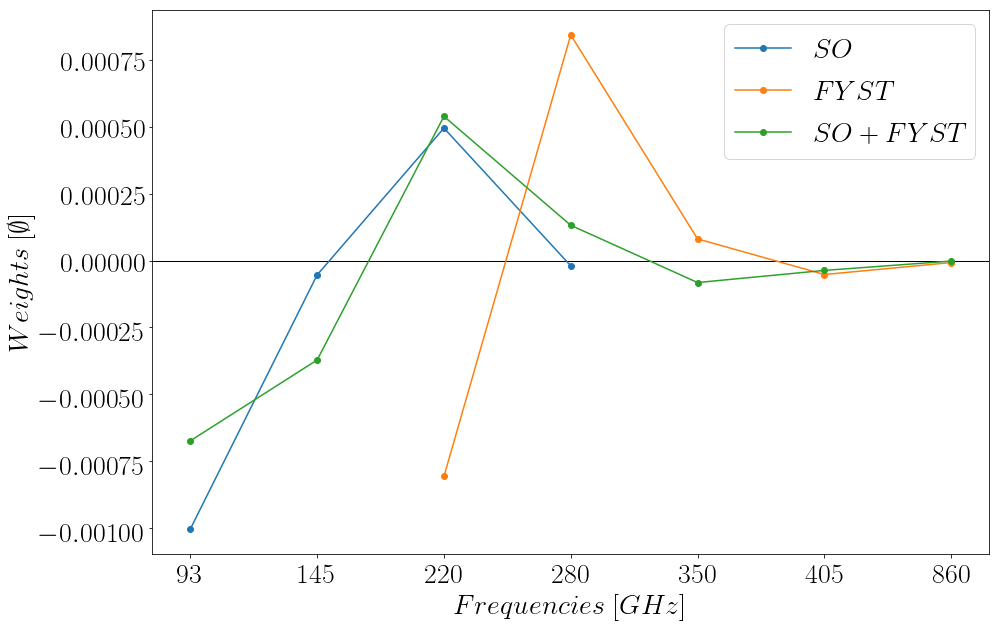

In [78]:
fig, ax = plt.subplots()
ax.axhline(y=0,color='black', lw=1)
plt.rcParams['figure.figsize'] = [15,10]
plt.plot(['$93$','$145$','$220$','$280$'],w_histo,'o-',label='$SO$')
plt.plot(['$220$','$280$','$350$','$405$','$860$'],w_histo_aFYST,'o-',label='$FYST$')
plt.plot(['$93$','$145$','$220$','$280$','$350$','$405$','$860$'],w_histo_SOFYST,'o-',label='$SO+FYST$')
plt.title('',fontsize=28) 
plt.xlabel('$Frequencies$ $[GHz]$',fontsize=28)
plt.ylabel('$Weights$ $[\emptyset]$',fontsize=28) #l(l+1)/2\pi 
plt.legend(fontsize=28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig('/users/mcharmetant/Desktop/Pictures/SO/' + 'test' + '.png') 
plt.show()

## Cumulative noise residual  

### SO : 

In [82]:
SO_rc = fmap + fmap_CIB

In [16]:
#hp.write_map('SO_rc_Extra.fits',SO_rc,overwrite=True) 

# Read healpix maps and initialize a spin-0 and spin-2 field
P_rc_SO = PyM.NmtField(mask,[hp.read_map('SO_rc_Extra.fits', field=0, verbose=False)])


# Initialize binning scheme with 4 ells per bandpower
bP_rc_SO = PyM.NmtBin.from_nside_linear(4096, 50)

# Compute MASTER estimator spin-0 x spin-0
cl_P_rc_SO = PyM.compute_full_master(P_rc_SO, P_rc_SO, bP_rc_SO)

### SO+FYST : 

In [79]:
SOFYST_rc = fmap_SOFYST_WN + fmap_SOFYST_CIB

In [17]:
#hp.write_map('SO+FYST_rc_Extra.fits',SOFYST_rc,overwrite=True) 

# Read healpix maps and initialize a spin-0 and spin-2 field
P_rc_SOFYST = PyM.NmtField(mask,[hp.read_map('SO+FYST_rc_Extra.fits', field=0, verbose=False)])


# Initialize binning scheme with 4 ells per bandpower
bP_rc_SOFYST = PyM.NmtBin.from_nside_linear(4096, 50)

# Compute MASTER estimator spin-0 x spin-0
cl_P_rc_SOFYST = PyM.compute_full_master(P_rc_SOFYST, P_rc_SOFYST, bP_rc_SOFYST)

In [22]:
R_rc= cl_P_rc_SOFYST[0]/cl_P_rc_SO[0]

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


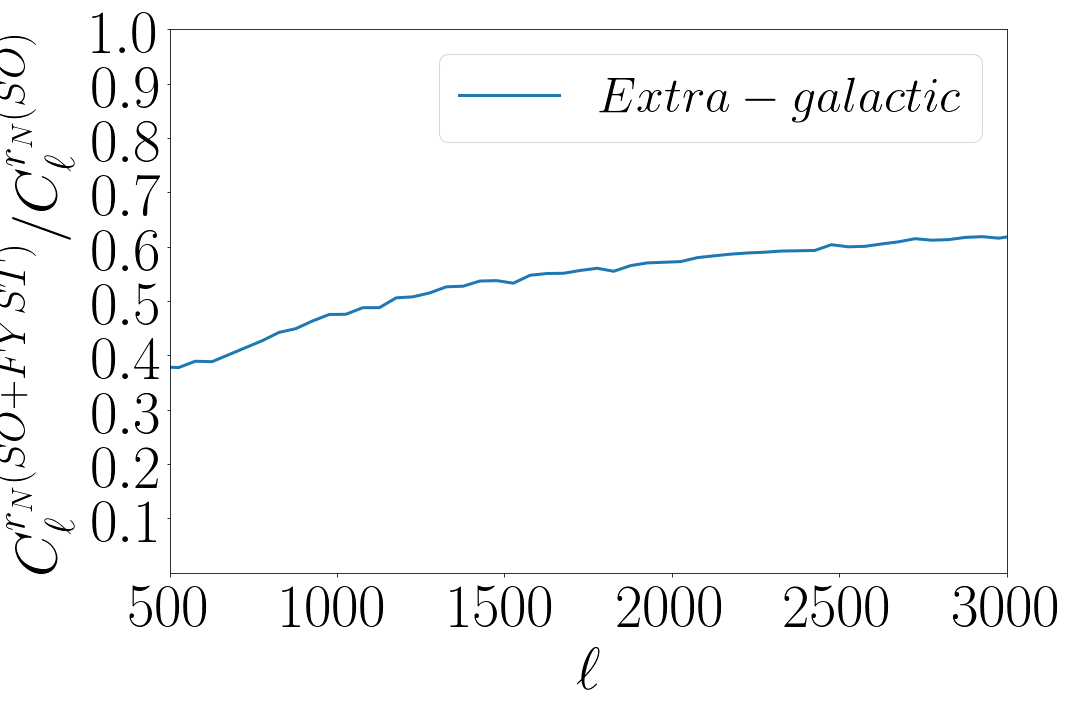

In [23]:
fig, ax = plt.subplots()
#ax.axhline(y=0.74,color='black',linestyle ='--', lw=1)
#ax.axhline(y=0.81,color='black',linestyle ='--', lw=1)
plt.rcParams['figure.figsize'] = [15,10]
plt.plot(ell_P_y,R_rc,label='$Extra-galactic$',linewidth=3.0)
#plt.plot(ell_P_y,RfG,label='$IN+CIB+GalD$',linewidth=3.0)
plt.xlabel('$\ell$',fontsize=60)
plt.ylabel('$C_{\ell}^{r_{N}(SO+FYST)}/C_{\ell}^{r_{N}(SO)}$',fontsize=60)#l(l+1)/2\pi 
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.xlim([500,3000])
#plt.ylim([10**-19,10**-17])
plt.ylim([0,1])
#plt.xscale('log')
#plt.yscale('log')
plt.legend(fontsize=50)
plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('test' + '.pdf', bbox_inches='tight', pad_inches=0.2)
plt.show()